In [1]:
import pandas as pd
import numpy as np
import re
import time

meld_data_path  = 'source_data/MELD/'
emory_data_path  = 'source_data/emorynlp/'

In [2]:
meld_train = pd.read_csv(meld_data_path + 'train_sent_emo.csv')
meld_valid = pd.read_csv(meld_data_path + 'dev_sent_emo.csv')
meld_test = pd.read_csv(meld_data_path + 'test_sent_emo.csv')

df_meld = pd.concat([meld_train,meld_valid,meld_test]).drop_duplicates()
df_meld.shape
df_meld.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company’s tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must’ve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let’s talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [3]:
emory_train = pd.read_csv(emory_data_path + 'emorynlp_train_final.csv')
emory_valid = pd.read_csv(emory_data_path + 'emorynlp_dev_final.csv')
emory_test = pd.read_csv(emory_data_path + 'emorynlp_test_final.csv')
df_emory = pd.concat([emory_train,emory_valid,emory_test]).drop_duplicates()
df_emory['Speaker'] = df_emory['Speaker'].apply(lambda x: eval(x)[0].split()[0])
df_emory['Utterance'] = df_emory['Utterance'].apply(lambda x: x.lower())
df_emory.shape

(9489, 9)

In [20]:
df_emory.head()

,Utterance,Speaker,Emotion,Scene_ID,Utterance_ID,Season,Episode,Start_Time,End_Time
0,"what you guys don't understand is, for us, kis...",Monica,Joyful,1,1,1,2,00:00:02.877,00:00:07.548
1,"yeah, right!.......y'serious?",Joey,Neutral,1,2,1,2,00:00:04.504,00:00:07.548
2,"oh, yeah!",Phoebe,Joyful,1,3,1,2,00:00:07.924,00:00:09.508
3,everything you need to know is in that first k...,Rachel,Powerful,1,4,1,2,00:00:11.970,00:00:17.683
4,absolutely.,Monica,Powerful,1,5,1,2,00:00:14.139,00:00:15.097


In [4]:
df_source = pd.read_csv('../big_5_analysis.tsv', sep='\t')
df_source['Season'] = df_source['scene_id'].apply(lambda x: int(x.split('_')[0]))
df_source['Episode'] = df_source['scene_id'].apply(lambda x: int(x.split('_')[1][1:]))
df_source.head()

,Unnamed: 0,Unnamed: 0.1,scene_id,text,character,cAGR,dialog_state,sent,utterance,context,labels,emoBERTa_large_labels,cCON,cEXT,cNEU,cOPN,bert_labels,Season,Episode
0,0,0,01_e01_c01,"[['Ross Geller', "" No!! Okay?! Why does everyo...",Joey,1,"[0, 0, 0, 0, 0, 1, 1, 0]",No!! Okay?! Why does everyone keep fixating o...,"Alright Ross, look. You're feeling a lot of ...",No!! Okay?! Why does everyone keep fixating ...,1,"['surprise', 'surprise', 'sadness', 'surprise'...",1,0,1,0,"['joy', 'anger', 'joy', 'fear', 'sadness', 'an...",1,1
1,1,1,01_e01_c02,"[['Monica Geller', "" Now I'm guessing that he ...",Chandler,1,"[0, 1, 0, 0, 0, 1, 0]",Now I'm guessing that he bought her the big p...,(imitating the characters) Tuna or egg salad...,Now I'm guessing that he bought her the big ...,1,"['neutral', 'neutral', 'neutral', 'sadness', '...",0,1,1,1,"['joy', 'joy', 'joy', 'sadness', 'anger', 'ang...",1,1
2,2,2,01_e01_c04,"[['Ross Geller', "" (squatting and reading the ...",Chandler,0,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]",(squatting and reading the instructions) I'm ...,It's a beautiful thing. I would have to say...,(squatting and reading the instructions) I'm...,0,"['anger', 'neutral', 'joy', 'neutral', 'neutra...",0,0,1,0,"['anger', 'joy', 'joy', 'anger', 'anger', 'ang...",1,1
3,3,4,01_e01_c08,"[['Paul', ' Ever since she walked out on me, I...",Monica,1,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]","Ever since she walked out on me, I, uh... Wha...","What?..... What, you wanna spell it out with...","Ever since she walked out on me, I, uh... N...",1,"['sadness', 'neutral', 'neutral', 'surprise', ...",0,1,1,1,"['anger', 'anger', 'joy', 'joy', 'anger', 'ang...",1,1
4,4,5,01_e01_c11,"[['Rachel Green', "" Isn't this amazing? I mean...",Chandler,0,"[0, 1, 0, 0, 1, 0]","Isn't this amazing? I mean, I have never made...","That is amazing. If can invade Poland, ther...","Isn't this amazing? I mean, I have never mad...",0,"['joy', 'joy', 'neutral', 'neutral', 'anger', ...",0,0,0,0,"['surprise', 'surprise', 'joy', 'joy', 'anger'...",1,1


In [5]:
def search_emory(row):
    uttr_list = eval(row['text'])
    emory_label = [0]*len(uttr_list)
    
    tmp_df = df_emory[(df_emory['Season'] == row['Season']) & 
                      (df_emory['Episode'] == row['Episode'])]
    
    for i in range(len(uttr_list)):
        uttr = uttr_list[i]
        for j,r in tmp_df.iterrows():
            if uttr[0].split()[0] == r['Speaker']:
                if (uttr[1].lower() == r['Utterance']) or (uttr[1].lower() in r['Utterance']) or  (r['Utterance'] in uttr[1].lower()):
                    emory_label[i] = r['Emotion']
                    
                    break
    
    return emory_label
df_source['emory_label'] = df_source.apply(search_emory, axis=1)

In [12]:
def search_meld(row):
    uttr_list = eval(row['text'])
    meld_label = [0]*len(uttr_list)
    
    tmp_df = df_meld[(df_meld['Season'] == row['Season']) & 
                      (df_meld['Episode'] == row['Episode'])]
#     print(tmp_df.shape)
    for i in range(len(uttr_list)):
        uttr = uttr_list[i]
        for j,r in tmp_df.iterrows():
            
            if uttr[0].split()[0] == r['Speaker']:
                
                if (uttr[1].lower() == r['Utterance']) or (uttr[1].lower() in r['Utterance']) or  (r['Utterance'] in uttr[1].lower()):
                    meld_label[i] = r['Emotion']
                    print(uttr)
                    print('************************************')
                    print(r['Speaker'], ' ### ',r['Utterance'])
                    break
                    
#     print(meld_label)  
    return meld_label
df_source['meld_label'] = df_source.apply(search_meld, axis=1)

['Chandler Bing', ' Here we go.']
************************************
Chandler  ###  Janice. Hi, Janice. Ok, here we go. I don't think we should go out anymore. Janice.
['Monica Geller', ' What?']
************************************
Monica  ###  About what?
['Rachel Green', ' What?']
************************************
Rachel  ###  "Ooo," what?
['Ross Geller', ' Look, I am totally, totally over her, OK, I just... (Rachel comes over, Ross lays head on table): Hiiii!']
************************************
Ross  ###  !
['Ross Geller', ' Look, I am totally, totally over her, OK, I just... (Rachel comes over, Ross lays head on table): Hiiii!']
************************************
Ross  ###  !
['Ross Geller', ' No.']
************************************
Ross  ###  No, no, no... why, because it might get weird for everyone else?
['Joey Tribbiani', ' Yeah.']
************************************
Joey  ###  Oh, yeah. He's got that great baby smell. Get a whiff of his head.
['Joey Tribbiani', 

In [38]:
emory_total = 0
meld_total = 0
total = 0
for i,r in df_source.iterrows():
    total += len(r['meld_label'])
    for k in r['meld_label']:
        if k != 0:
            meld_total += 1
    for k in r['emory_label']:
        if k != 0:
            emory_total += 1

print(float(emory_total)/total)
print(float(meld_total)/total)

0.2839933744917934
0.0022586959795211563


In [19]:
def has_label(li, pure=False):

    if not pure:
        # not pure    
        for i in li:
            if i != 0:
                return True
        return False
    else:
        # pure
        for i in li:
            if i == 0:
                return False
        return True
df_source['Emory_available'] = df_source['emory_label'].apply(has_label)
df_source_emory = df_source[df_source['Emory_available'] == True]
df_source_emory.shape

(334, 22)

In [20]:
df_source_emory.head()

,Unnamed: 0,Unnamed: 0.1,scene_id,text,character,cAGR,dialog_state,sent,utterance,context,...,cCON,cEXT,cNEU,cOPN,bert_labels,Season,Episode,emory_label,meld_label,Emory_available
2,2,2,01_e01_c04,"[['Ross Geller', "" (squatting and reading the ...",Chandler,0,"[0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0]",(squatting and reading the instructions) I'm ...,It's a beautiful thing. I would have to say...,(squatting and reading the instructions) I'm...,...,0,0,1,0,"['anger', 'joy', 'joy', 'anger', 'anger', 'ang...",1,1,"[Mad, Neutral, Joyful, Neutral, 0, Neutral, Sc...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",True
3,3,4,01_e01_c08,"[['Paul', ' Ever since she walked out on me, I...",Monica,1,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1]","Ever since she walked out on me, I, uh... Wha...","What?..... What, you wanna spell it out with...","Ever since she walked out on me, I, uh... N...",...,0,1,1,1,"['anger', 'anger', 'joy', 'joy', 'anger', 'ang...",1,1,"[0, 0, 0, 0, Scared, 0, 0, 0, Sad, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",True
11,11,13,01_e02_c08,"[['Ross Geller', "" So, um- so how's this, uh, ...",Ross,0,"[1, 0, 1, 0, 1, 0, 1]","So, um- so how's this, uh, how's this gonna w...","So, um- so how's this, uh, how's this gonna ...",Give me a 'for instance'. Marlon- -if it's...,...,1,1,0,1,"['joy', 'joy', 'joy', 'anger', 'anger', 'anger...",1,2,"[0, Mad, Scared, Powerful, Mad, Powerful, Mad]","[0, 0, 0, 0, 0, 0, 0]",True
12,12,14,01_e02_c11,"[['Ross Geller', "" Well? Isn't that amazing?""]...",Ross,1,"[1, 0, 0, 0, 1, 0, 1, 0, 1, 0]",Well? Isn't that amazing? What are we suppose...,Well? Isn't that amazing? Then don't do tha...,What are we supposed to be seeing here? I d...,...,0,0,0,1,"['joy', 'fear', 'anger', 'joy', 'joy', 'joy', ...",1,2,"[Joyful, Neutral, Joyful, Joyful, Mad, Neutral...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",True
13,13,15,01_e03_c03,"[['Phoebe Buffay', "" - and there's five hundre...",Rachel,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1]",- and there's five hundred extra dollars in m...,"Yeah, but if you spent it, it would be like ...",- and there's five hundred extra dollars in ...,...,1,0,0,1,"['anger', 'anger', 'anger', 'anger', 'anger', ...",1,3,"[0, 0, 0, 0, 0, 0, Neutral, 0, Neutral, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",True


Positive Emotions 341.0
Negative Emotions 276.0
********************************
Positive Emotions 295.0
Negative Emotions 322.0
********************************
Positive Emotions 247.0
Negative Emotions 370.0
********************************
Positive Emotions 282.0
Negative Emotions 335.0
********************************
Positive Emotions 383.0
Negative Emotions 234.0
********************************


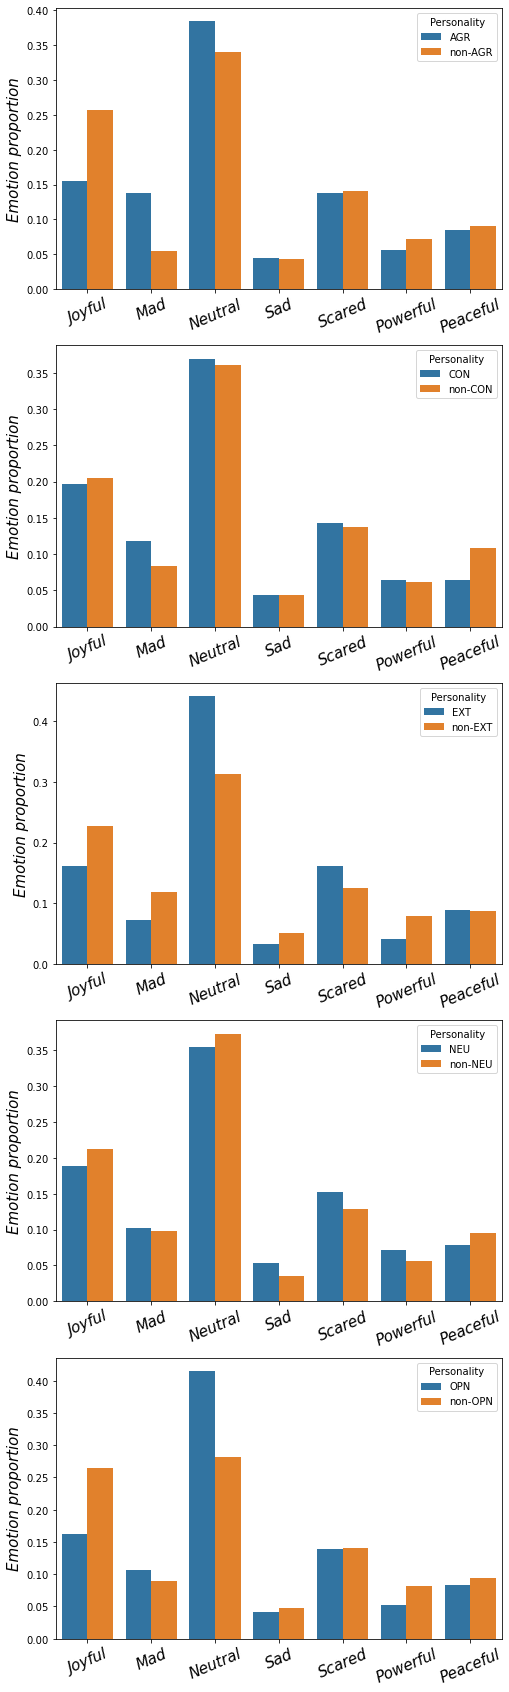

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt


emo_dict = {
    'Joyful' : 0,
    'Mad'    : 1,
    'Neutral': 2,
    'Sad'    : 3,
    'Scared' : 4,
    'Powerful': 5,
    'Peaceful': 6,
}    



ps = ['cAGR', 'cCON', 'cEXT', 'cNEU', 'cOPN']
emo_all = []
for p in ps:
    pos_df = df_source_emory[df_source_emory[p] == 1]
    pos_emo = np.zeros([7,1])
    for i,r in pos_df.iterrows():
        for j in range(len(eval(r['dialog_state']))-1):
            if (eval(r['dialog_state'])[j] == 1):
                if r['emory_label'][j] != 0:
                    pos_emo[emo_dict[r['emory_label'][j]]] += 1


    neg_df = df_source_emory[df_source_emory[p] == 0]
    neg_emo = np.zeros([7,1])
    for i,r in neg_df.iterrows():
        for j in range(len(eval(r['dialog_state']))-1):
            if (eval(r['dialog_state'])[j] == 1):
                if r['emory_label'][j] != 0:
                    neg_emo[emo_dict[r['emory_label'][j]]] += 1
    

    
    print('Positive Emotions', pos_emo.sum())
    print('Negative Emotions', neg_emo.sum())
    print('********************************')
    
    pos_emo = pos_emo/pos_emo.sum()
    neg_emo = neg_emo/neg_emo.sum()
    
    
    
    
    emo_all.append(pos_emo)
    emo_all.append(neg_emo)

dfs = []
    
for i in range(len(emo_all)):
    tmp_df = pd.DataFrame(emo_all[i])
    if i % 2 == 0:
        tmp_df['Personality'] = ps[int(i/2)][1:]
    else:
        tmp_df['Personality'] = 'non-' + ps[int(i/2)][1:]
    
    dfs.append(tmp_df)
# dfs = pd.concat(dfs, axis=0)


fig,axn = plt.subplots(5, 1, sharey=False, figsize=(8,30))
cap_emo_list = emo_dict.keys()
emos = np.arange(0,7)

cnt = 0
for ax in axn.flat:
    std_list = []
    std_df = pd.concat([dfs[cnt],dfs[cnt+1]], axis=0)


    sns.barplot(x=std_df.index, y=0, data=std_df, ax=ax, hue='Personality')
    ax.set_xticklabels(cap_emo_list, rotation=23, fontsize=15, fontstyle='oblique', fontweight='550')
    ax.set_ylabel('Emotion proportion', fontsize=15, fontstyle='oblique', fontweight='550')



    cnt += 2

plt.savefig('./Emotion_std.png', dpi=600)


In [39]:
emo_all = pd.DataFrame(emo_all[0])
emo_all['Personality'] = 'AGR'
emo_all_ = emo_all.copy()
emo_all_['Personality'] = 'non-AGR'
emo_all = pd.concat([emo_all, emo_all_], axis=0)
emo_all



,0,Personality
0,0.257246,AGR
1,0.054348,AGR
2,0.340580,AGR
3,0.043478,AGR
4,0.141304,AGR
5,0.072464,AGR
6,0.090580,AGR
0,0.257246,non-AGR
1,0.054348,non-AGR
2,0.340580,non-AGR


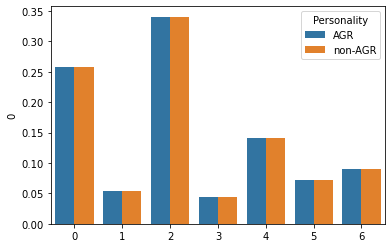

In [54]:
%matplotlib inline
import matplotlib
sns.barplot(x=emo_all.index, y=0, data=emo_all, hue='Personality')
# ax.set_xticklabels(cap_emo_list, rotation=23, fontsize=15, fontstyle='oblique', fontweight='550')
plt.show()
# plt.savefig('./Emotion_std.png', dpi=600)

In [53]:
emo_all

,0,Personality
0,0.257246,AGR
1,0.054348,AGR
2,0.340580,AGR
3,0.043478,AGR
4,0.141304,AGR
5,0.072464,AGR
6,0.090580,AGR
0,0.257246,non-AGR
1,0.054348,non-AGR
2,0.340580,non-AGR
